In [195]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import itertools
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [196]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [197]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [198]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [199]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [200]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2 , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)
train_df:  (200, 18)
test_df:  (50, 18)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


# Load Data

# tsa.SARIMAX

In [201]:
taylor_df = load_taylor()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
holston_df: (250, 4)


In [202]:
train_df, test_df = time_split(taylor_df)

train_df:  (200, 18)
test_df:  (50, 18)


In [203]:
#X_train = train2006_df[['FEDFUNDS-1']]
X_train = train_df[['FEDFUNDS-1','recession_flag','gap_inf', 'Real_Interest_Rate', 'gap_ue']]

#X_train_trf = t_fit.transform(X_train)


y_train = train_df['FEDFUNDS']

In [204]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['recession_flag','chair_name']
cat_columns_lst = ['recession_flag']
num_columns_lst = ['FEDFUNDS-1','gap_inf', 'Real_Interest_Rate', 'gap_ue']
#num_columns_lst = ['gap_inf', 'gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [205]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)


#X_train_const = sm.add_constant(X_train_trf)

# Define ranges for p, d, q, P, D, Q, and seasonal period
p_values = range(0, 3)  # Range for p (AR parameter)
d_values = range(0, 2)  # Range for d (Differencing parameter)
q_values = range(0, 3)  # Range for q (MA parameter)
P_values = range(0, 3)  # Range for seasonal P parameter
D_values = range(0, 2)  # Range for seasonal D parameter
Q_values = range(0, 3)  # Range for seasonal Q parameter
s_values = [4]  # Seasonal period (e.g., 12 for monthly data)

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate over different orders to find the best model
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            seasonal_order = (P, D, Q, s)
                            order = (p, d, q)
                            try:
                                #$model = sm.tsa.SARIMAX(ts_data, order=order, seasonal_order=seasonal_order)
                                print('order:' , order , ' seasonal_order: ' ,seasonal_order)
                                model = sm.tsa.SARIMAX(y_train, order=order, seasonal_order=seasonal_order , enforce_stationarity=True, exog=X_train_trf)
                                results = model.fit(disp=False)
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

# Print the best orders found
print("Best AIC:", best_aic)
print("Best Order (p, d, q):", best_order)
print("Best Seasonal Order (P, D, Q, s):", best_seasonal_order)

In [206]:
# Define ranges for p, d, q, P, D, Q, and seasonal period
p_values = range(0, 3)  # Range for p (AR parameter)
d_values = range(0, 2)  # Range for d (Differencing parameter)
q_values = range(0, 3)  # Range for q (MA parameter)


best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate over different orders to find the best model
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                #$model = sm.tsa.SARIMAX(ts_data, order=order, seasonal_order=seasonal_order)
                print('order:' , order)
                model = sm.tsa.SARIMAX(y_train, order=order, enforce_stationarity=True, exog=X_train_trf)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    #best_seasonal_order = seasonal_order
            except:
                continue
# Print the best orders found
print("Best AIC:", best_aic)
print("Best Order (p, d, q):", best_order)
#print("Best Seasonal Order (P, D, Q, s):", best_seasonal_order)

order: (0, 0, 0)
order: (0, 0, 1)
order: (0, 0, 2)
order: (0, 1, 0)
order: (0, 1, 1)
order: (0, 1, 2)
order: (1, 0, 0)
order: (1, 0, 1)
order: (1, 0, 2)
order: (1, 1, 0)
order: (1, 1, 1)
order: (1, 1, 2)
order: (2, 0, 0)
order: (2, 0, 1)
order: (2, 0, 2)
order: (2, 1, 0)
order: (2, 1, 1)
order: (2, 1, 2)
Best AIC: 475.24505841201915
Best Order (p, d, q): (2, 1, 2)


In [233]:
#model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(2,1,2), seasonal_order=(0, 0, 0, 4), enforce_stationarity=True, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4), enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=(1,0,0), exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  200
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -255.064
Date:                Mon, 20 Nov 2023   AIC                            524.128
Time:                        23:06:47   BIC                            547.217
Sample:                    03-31-1961   HQIC                           533.472
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__FEDFUNDS-1                             0.9102      0.039     23.571      0.000       0.835       0.986
num__gap_inf                                0.1448      0.042      3.444      0.001       0.062       0.227
num__Real_Interest_Rate                     0.1300      0.063      2.059      0.039       0.006       0.254
num__gap_ue                                 0.0968      0.070      1.375      0.169      -0.041       0.235
cat__onehotencoder__recession_flag_True    -0.6997      0.208     -3.368      0.001      -1.107      -0.293
ar.L1                                       0.1817      0.068      2.692      0.007       0.049       0.314
sigma2                                      0.7501      0.037     20.399      0.000       0.678       0.822
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              1463.20
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [234]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [235]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-03-31,2.500241,0.880774,0.773956,4.226526
1961-06-30,2.238456,0.880774,0.512171,3.964741
1961-09-30,1.991269,0.880774,0.264984,3.717554
1961-12-31,1.998391,0.880774,0.272106,3.724677
1962-03-31,2.728109,0.880774,1.001824,4.454394
...,...,...,...,...
2009-12-31,-0.463343,0.880774,-2.189628,1.262942
2010-03-31,-0.448497,0.880774,-2.174782,1.277788
2010-06-30,-0.329064,0.880774,-2.055350,1.397221
2010-09-30,-0.241558,0.880774,-1.967844,1.484727


## Test

In [236]:
#X_test = test_df[['FEDFUNDS-1','gap_inf', 'gap_ue', 'Real_Interest_Rate', 'recession_flag']]
X_test = test_df[['FEDFUNDS-1','recession_flag','gap_inf', 'Real_Interest_Rate', 'gap_ue']]
X_test_trf = t_fit.transform(X_test)

y_test = train_df['FEDFUNDS']

In [237]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [238]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(50, 4)

In [239]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS,upper FEDFUNDS
2011-03-31,-0.667145,0.501215
2011-06-30,-0.714536,0.472961
2011-09-30,-0.755318,0.432806
2011-12-31,-0.787316,0.400829
2012-03-31,-0.728980,0.459166


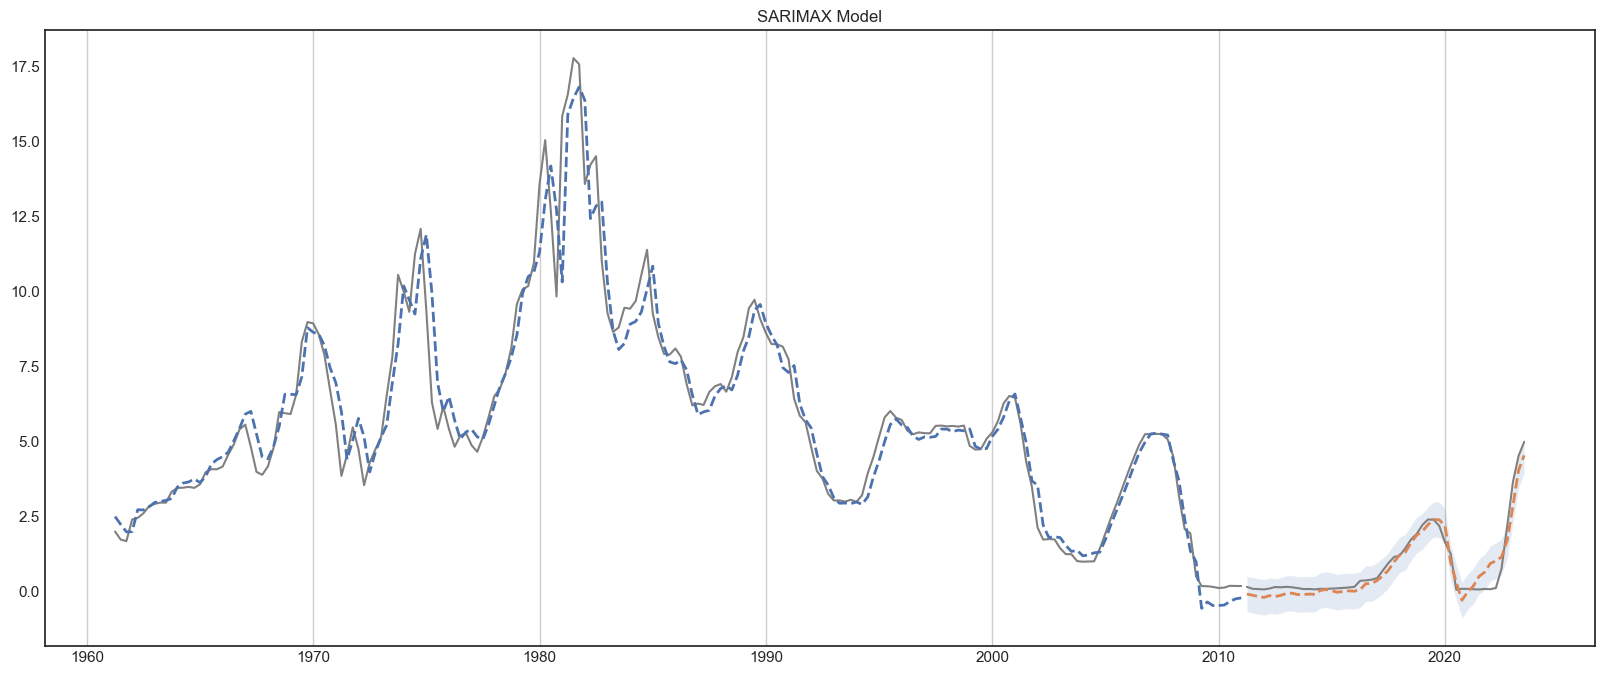

In [240]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [241]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX RMSE(Train): 0.8809232585819045
SARIMAX RMSE(Test): 0.3234493102056178


In [242]:
print('SARIMAX R-Squard(Train):' , r2_score(train_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX R-Squard(Train): 0.9335064017502345
SARIMAX R-Squard(Test): 0.9235398305087551


In [243]:
X_train.shape[1]

5

In [244]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,SARIMAX_train,0.9335,0.9321,0.7760,0.8809
7,SARIMAX_test,0.9235,0.9167,0.1046,0.3234
8,SARIMAX_train,-1.8910,-1.9503,33.7395,5.8086
9,SARIMAX_test,-14.7443,-16.1438,21.5427,4.6414
